In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as style
from tqdm import tqdm 
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
style.use('ggplot')
import os
os.chdir('../')
from python_code import basic_gibbs
os.chdir('notebooks')
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [2]:
from scipy.stats import norm
from ridgeplot import ridgeplot
import plotly.offline as pyo
pyo.init_notebook_mode()

In [3]:
def make_ridge(beta_no, b=.5):
    data = pd.DataFrame(gb.traces['betas'][:,beta_no,:]).dropna(axis=0).to_numpy().T
    fig = ridgeplot(
    samples= data, 
    bandwidth=b,
    kde_points=np.linspace(data.min(), data.max(), 400),
    colorscale="peach",
    colormode="mean-means",
    coloralpha=0.6,
    labels=[no for no in range(len(groups))],
    spacing=5 / 9,
)
    fig.update_layout(showlegend=False, height=900,
    width=500, title=f'\u03B2<sub>{beta_no}</sub> per department', title_x=0.5,  plot_bgcolor="rgba(255, 255, 255, 0.0)")
    fig.show()

In [4]:
df = pd.read_csv('../formatted_data/transformed_data.csv')
grouped_df = df.groupby('department_name')
groups = list(grouped_df.groups.keys())
X_depts = list(grouped_df.apply(lambda x: np.array(x[['intercept', 'component_1', 'component_2']])))
y_depts = list(grouped_df.apply(lambda x: np.array(x[['avg_change_baseline_incidents']]).flatten()))

In [7]:
gb = basic_gibbs.GibbsSampler(X_depts, y_depts, n_iter=10000, burn=1000)
gb.fit()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:04<00:00, 80.06it/s]


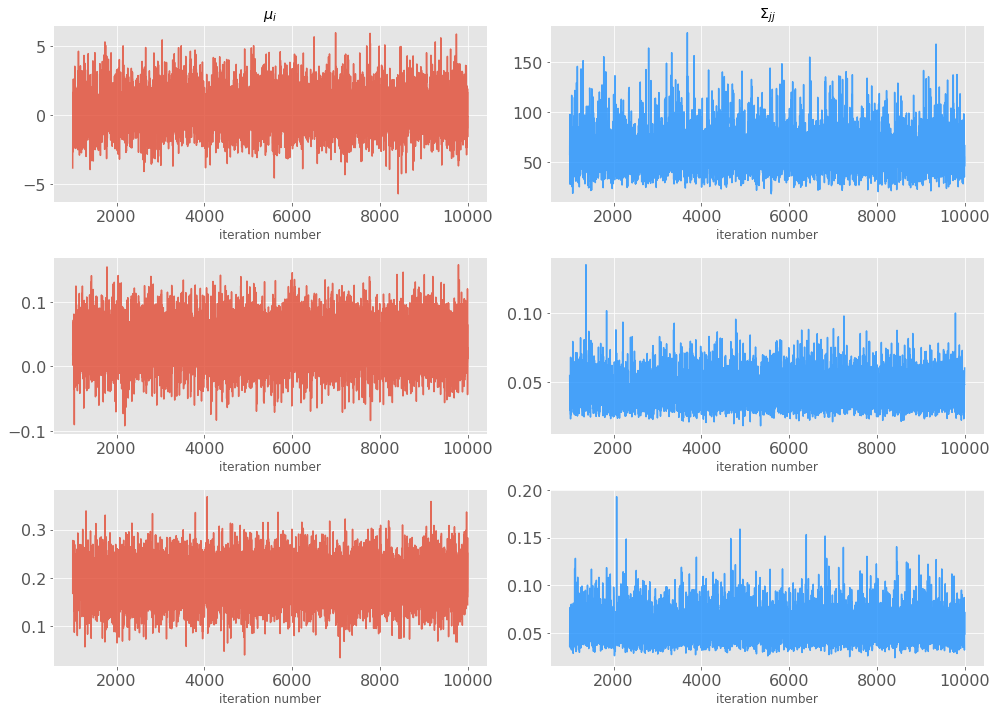

In [27]:
fig = plt.figure(figsize=(14,10), facecolor='white')
for i in range(3):
    x = np.arange(1000, 10000, 1)
    plt.subplot(3, 2, 2*i+1)
    if i == 0:
        plt.title(r'$\mu_i$')
    plt.plot(x, gb.traces['mu'][:,i], lw=1.5, alpha=.8)
    plt.xlabel('iteration number')
    plt.subplot(3, 2, 2*i+2)
    plt.plot(x, gb.traces['sigmas_diag'][:,i], lw=1.5, color='dodgerblue', alpha=.8)
    plt.xlabel('iteration number')
    if i == 0:
        plt.title(r'$\Sigma_{jj}$')
        
plt.tight_layout()
plt.savefig('../figures/traces_simple_model.png', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

In [28]:
betas = np.nanmean(gb.traces['betas'], axis=0)

In [29]:
pd.DataFrame([gb.traces['mu'].mean(axis=0), gb.traces['sigmas_diag'].mean(axis=0)]).round(3)

0      1      2
0   0.429  0.035  0.193
1  59.096  0.043  0.057

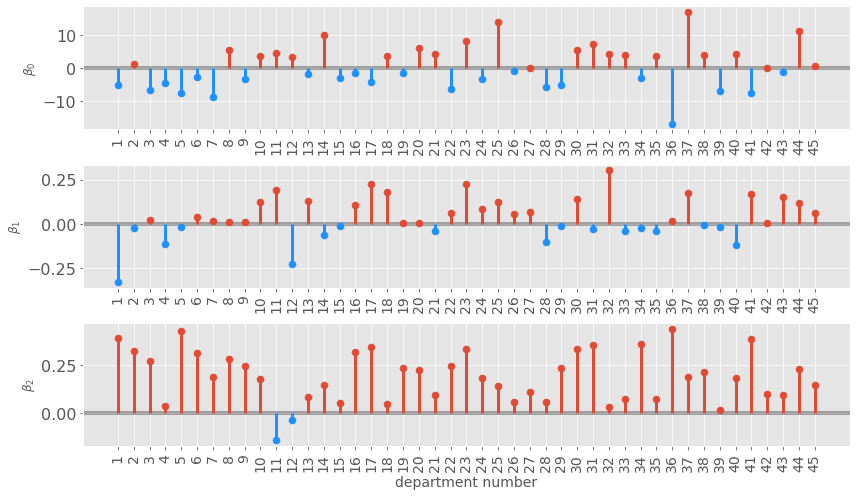

In [30]:
fig = plt.figure(figsize=(12,7), facecolor='white')
for beta in range(3):
    plt.subplot(3, 1, beta+1)
    depts = np.arange(1, 46, 1)
    plt.xticks(depts, fontsize=14)
    plt.axhline(y=0, color='black',alpha=.3)
    plt.xticks(rotation=90)
    _, stemlines, baseline = plt.stem(depts[betas[beta,:] > 0], betas[beta,:][betas[beta,:] > 0], markerfmt=' ')
    plt.setp(stemlines, 'linewidth', 3)
    plt.setp(baseline, 'linewidth', 0)
    plt.scatter(depts[betas[beta,:] > 0], betas[beta,:][betas[beta,:] > 0],  s=50, zorder=2);
    _, stemlines, baseline = plt.stem(depts[betas[beta,:] < 0], betas[beta,:][betas[beta,:] < 0], markerfmt=' ')
    plt.setp(stemlines, 'linewidth', 3, 'color', 'dodgerblue')
    plt.setp(baseline, 'linewidth', 0)
    plt.scatter(depts[betas[beta,:] < 0], betas[beta,:][betas[beta,:] < 0], color='dodgerblue', s=50, zorder=2);
    plt.ylabel(fr'$\beta_{beta}$')
plt.xlabel('department number', fontsize=14);
plt.tight_layout()
plt.savefig('../figures/mean_betas.png', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

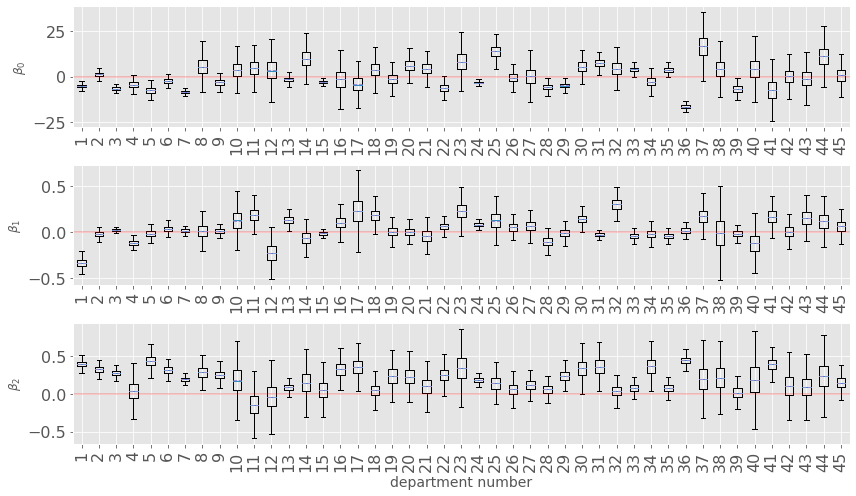

In [32]:
fig = plt.figure(figsize=(12,7), facecolor='white')
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.boxplot(gb.traces['betas'][:,i,:], vert=True, showfliers=False, showmeans=True, meanline=True)
    plt.axhline(y=0, color='red', alpha=.2, lw=2)
    plt.ylabel(fr'$\beta_{i}$')
    plt.xticks(rotation=90)
plt.xlabel('department number', fontsize=14);
plt.tight_layout()
plt.savefig('../figures/box_plots.png', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

In [33]:
df_pop = pd.read_csv('../raw_data/pop_data.csv')
df_fips = pd.read_csv('../formatted_data/county_fips_per_department.csv')
df_fips = df_fips.rename(columns={'county_fips_code':'fips'})
dept_pop_counts = pd.merge(df_fips, df_pop, how='inner', on='fips')
departments_kept = pd.DataFrame(pd.unique(df['department_name']), columns=['department_name'])
final_df = pd.merge(dept_pop_counts, departments_kept, how='inner', on='department_name').sort_values('department_name')
final_df['fips'] = final_df['fips'].apply(lambda x: int(str(x)[0:2]))
df_state = pd.read_csv('../raw_data/us-state-ansi-fips.csv')
df_state.columns = ['full_state', 'fips','state_letters']
df_state['fips'] = df_state['fips'].astype(int)
final_df = pd.merge(final_df, df_state, on='fips').sort_values('department_name')

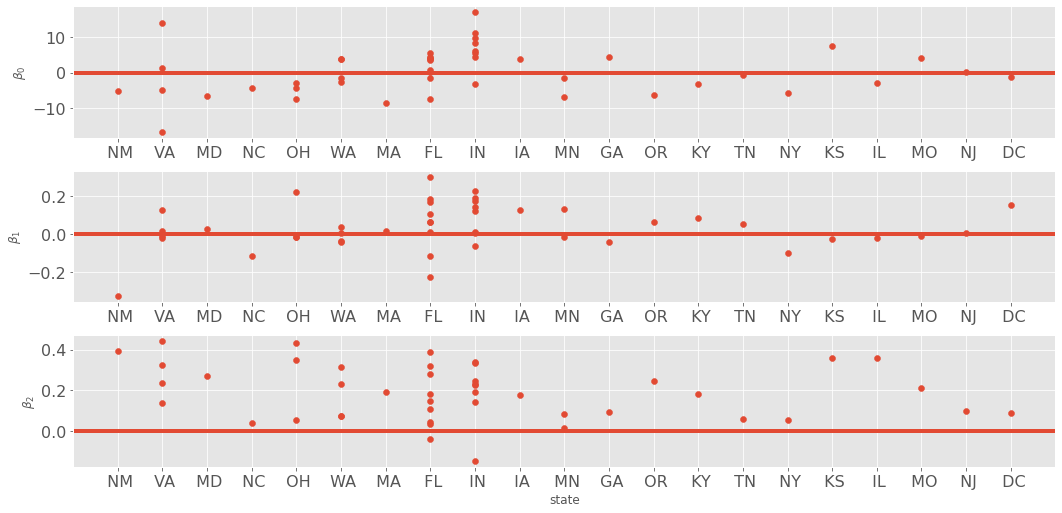

In [34]:
fig = plt.figure(figsize=(15,7), facecolor='white')
for beta in range(3):
    plt.subplot(3,1, beta+1)
    plt.scatter(final_df['state_letters'], betas[beta, :])
    plt.ylabel(fr'$\beta_{beta}$')
    plt.axhline(y=0)
plt.tight_layout()
plt.xlabel('state')
plt.savefig('../figures/state_and_betas.png', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

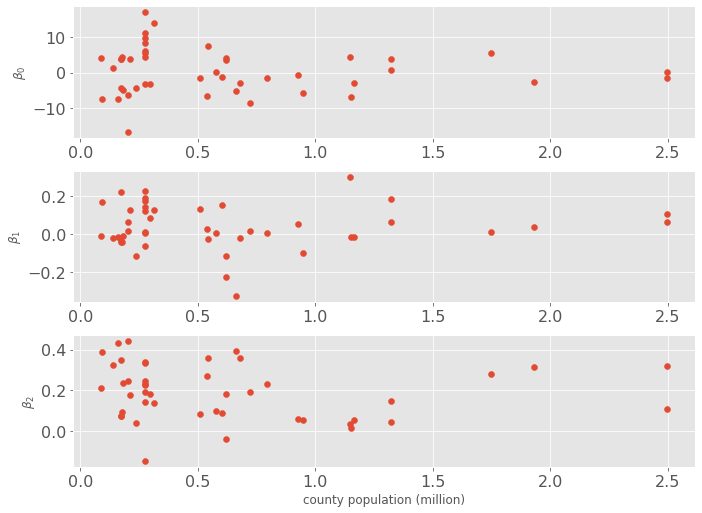

In [35]:
plt.figure(figsize=(10,7), facecolor='white')
for beta in range(3):
    plt.subplot(3,1, beta+1)
    plt.scatter(final_df['CENSUS2010POP']/1e6, betas[beta, :])
    plt.ylabel(fr'$\beta_{beta}$')
plt.tight_layout()
plt.xlabel('county population (million)')
plt.savefig('../figures/population_and_betas.png', dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())

In [36]:
all_coeffs = np.zeros([3,len(groups)])
for i in range(len(groups)):
    for beta in range(3):
        numerator = 1/gb.traces['sigmas_diag'][:, beta]
        denominator = (gb.traces['sigmas_squared'][:, i]) * (X_depts[i][:, beta]@X_depts[i][:, beta]) +  1/gb.traces['sigmas_diag'][:, beta]
        ki =  (numerator/denominator).mean()
        all_coeffs[beta, i] = ki

In [37]:
ols_betas = [np.linalg.inv(X_depts[i].T@X_depts[i])@X_depts[i].T@y_depts[i] for i in range(len(groups))]

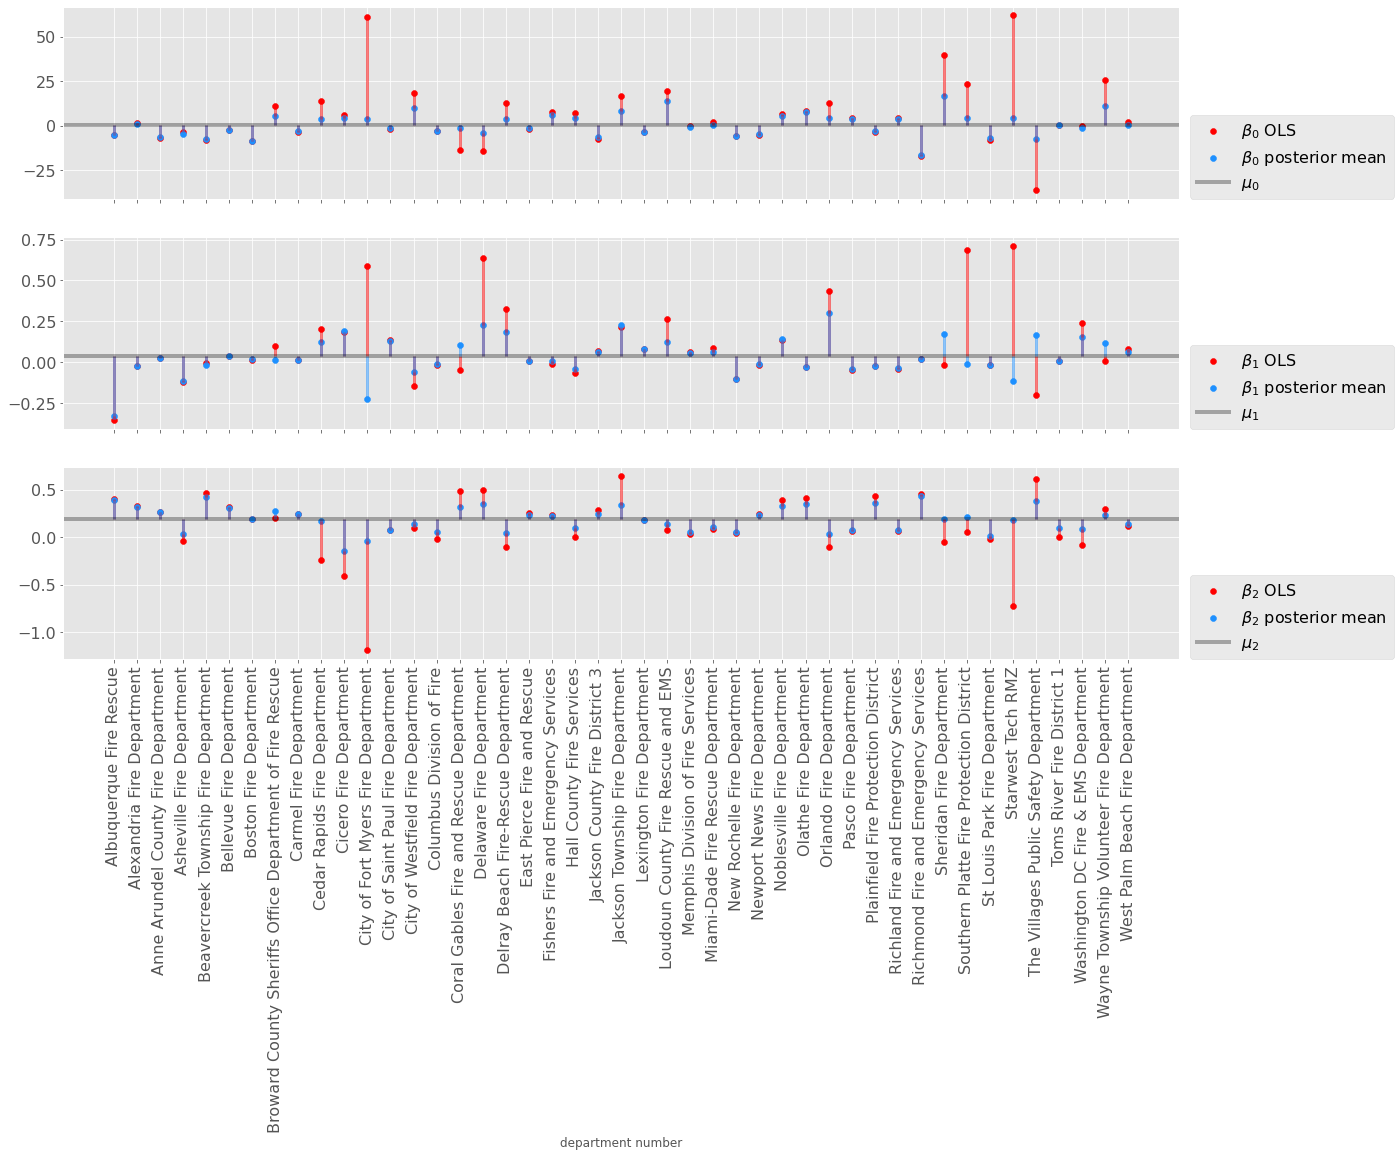

In [62]:
plt.figure(figsize=(20,12), facecolor='white')

depts = list(grouped_df.groups.keys())
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.scatter(depts, [ols[i] for ols in ols_betas], label=fr'$\beta_{i}$ OLS', color='red')
    plt.scatter(depts, betas[i, :], label=fr'$\beta_{i}$ posterior mean', color='dodgerblue')
    _, stemlines, baseline = plt.stem(depts, [ols[i] for ols in ols_betas], bottom=gb.traces['mu'].mean(axis=0)[i], markerfmt=' ')
    plt.setp(stemlines, 'linewidth', 3, 'color','red', 'alpha',.5)
    plt.setp(baseline, 'linewidth', 0)
    
    _, stemlines, baseline = plt.stem(depts, betas[i, :], bottom=gb.traces['mu'].mean(axis=0)[i], markerfmt=' ')
    plt.setp(stemlines, 'linewidth', 3, 'color','dodgerblue', 'alpha',.5)
    plt.setp(baseline, 'linewidth', 0)
    
    plt.axhline(y=gb.traces['mu'].mean(axis=0)[i], color='black',alpha=.3, label=fr'$\mu_{i}$')
    
    if i < 2:
        plt.xticks(color='white')
    plt.xticks(rotation=90)
    plt.legend(loc=(1.01,0))

plt.xlabel('department number');
plt.savefig('../figures/shrinkage.png', dpi=300, bbox_inches='tight')

In [51]:
len_data = grouped_df.size().to_numpy()

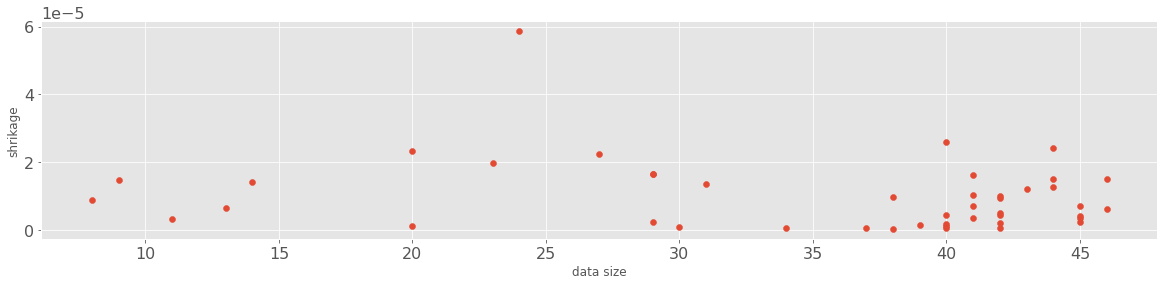

<Figure size 432x288 with 0 Axes>

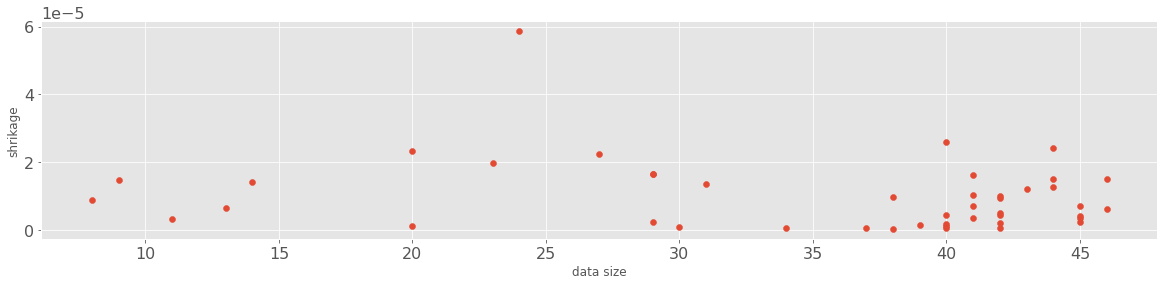

<Figure size 432x288 with 0 Axes>

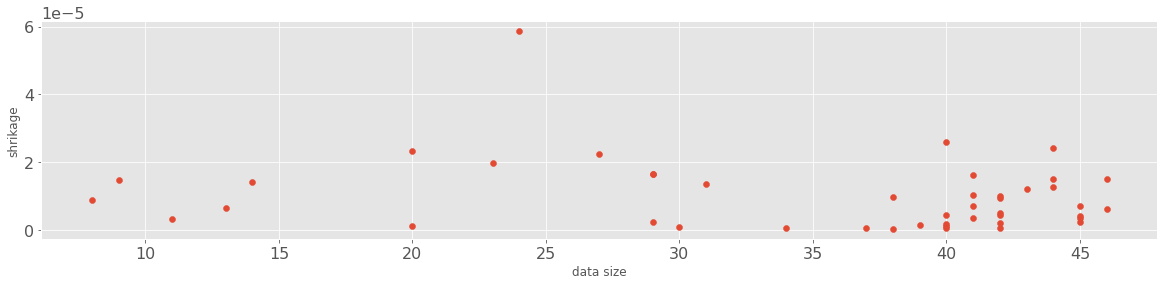

<Figure size 432x288 with 0 Axes>

In [52]:
def plot_coeff_with_size(len_data, coef_no):
    plt.figure(figsize=(20,4), facecolor='white')
    plt.scatter(len_data, all_coeffs[0, :]) 
    plt.ylabel('shrikage')
    plt.xlabel('data size')
    plt.figure()
for n in range(3):
    plot_coeff_with_size(len_data, n)
    

In [53]:
pca_correlations = grouped_df.apply(lambda x: x['component_1'].corr(x['component_2'])).to_frame(name='corr').reset_index()

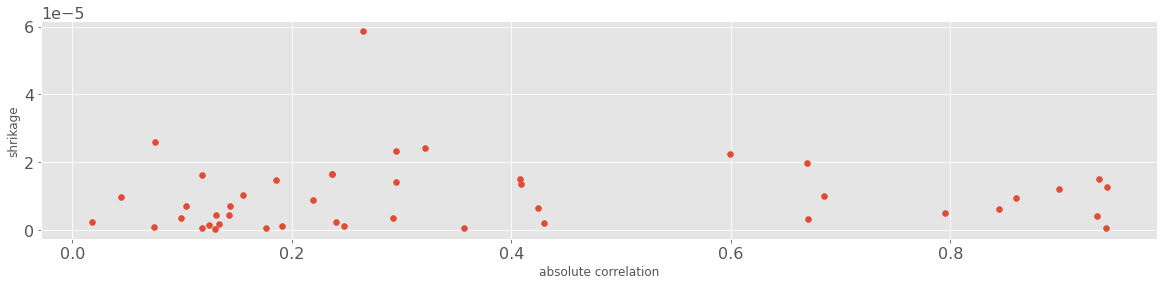

<Figure size 432x288 with 0 Axes>

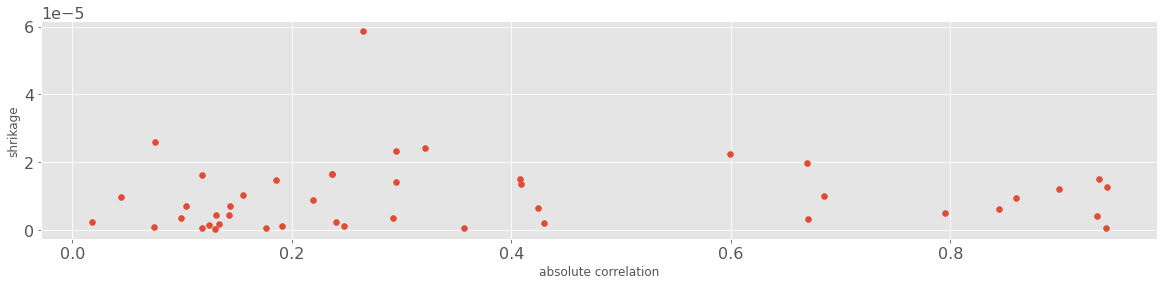

<Figure size 432x288 with 0 Axes>

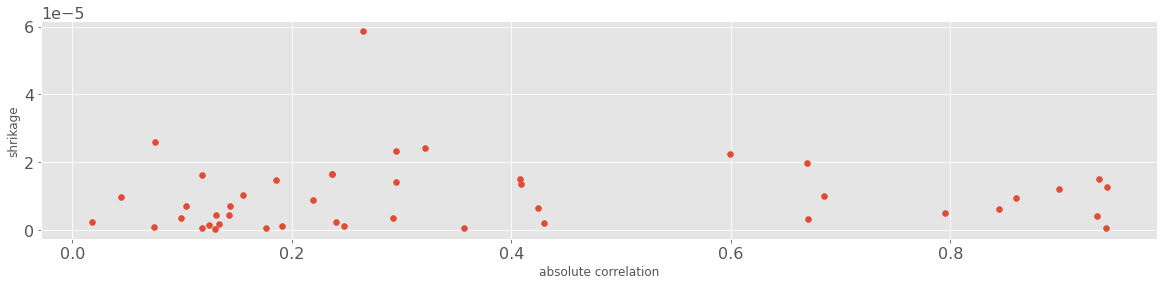

<Figure size 432x288 with 0 Axes>

In [54]:
def plot_coeff_with_size(len_data, coef_no):
    plt.figure(figsize=(20,4), facecolor='white')
    plt.scatter(np.abs(pca_correlations['corr']), all_coeffs[0, :]) 
    plt.ylabel('shrikage')
    plt.xlabel('absolute correlation')
    plt.figure()
for n in range(3):
    plot_coeff_with_size(len_data, n)

In [279]:
def plot_fit(df, betas, name, ax_number, all_axes):
    ax = all_axes.flatten()[ax_number]
    reg = LinearRegression()
    reg.fit(df[['component_1', 'component_2']], df['avg_change_baseline_incidents'])
    ax.plot(df['day_of_the_year'], df[['intercept', 'component_1', 'component_2']]@betas[:, None], label='gibbs')
    ax.scatter(df['day_of_the_year'], df['avg_change_baseline_incidents'], alpha=.3, label='data', color='black')
    ax.plot(df['day_of_the_year'], reg.predict(df[['component_1', 'component_2']]), label='OLS')
    ax.set_title(name)
    ax.set_xlabel('day of 2020')
    ax.set_ylabel('% inc change')
    if ax_number == 0:
        ax.legend()
    plt.close()

betas_df = pd.DataFrame(betas, columns=grouped_df.groups)

fig, axes = plt.subplots(9 , 5, figsize=(25, 30), facecolor='white') 
grouped_df.apply(lambda x: plot_fit(x, betas=betas_df[x.name].to_numpy(), name=x.name, ax_number=depts.index(x.name), all_axes=axes)).to_numpy()
fig.tight_layout()
fig.savefig('../figures/check_fit.png', dpi=300, bbox_inches='tight')

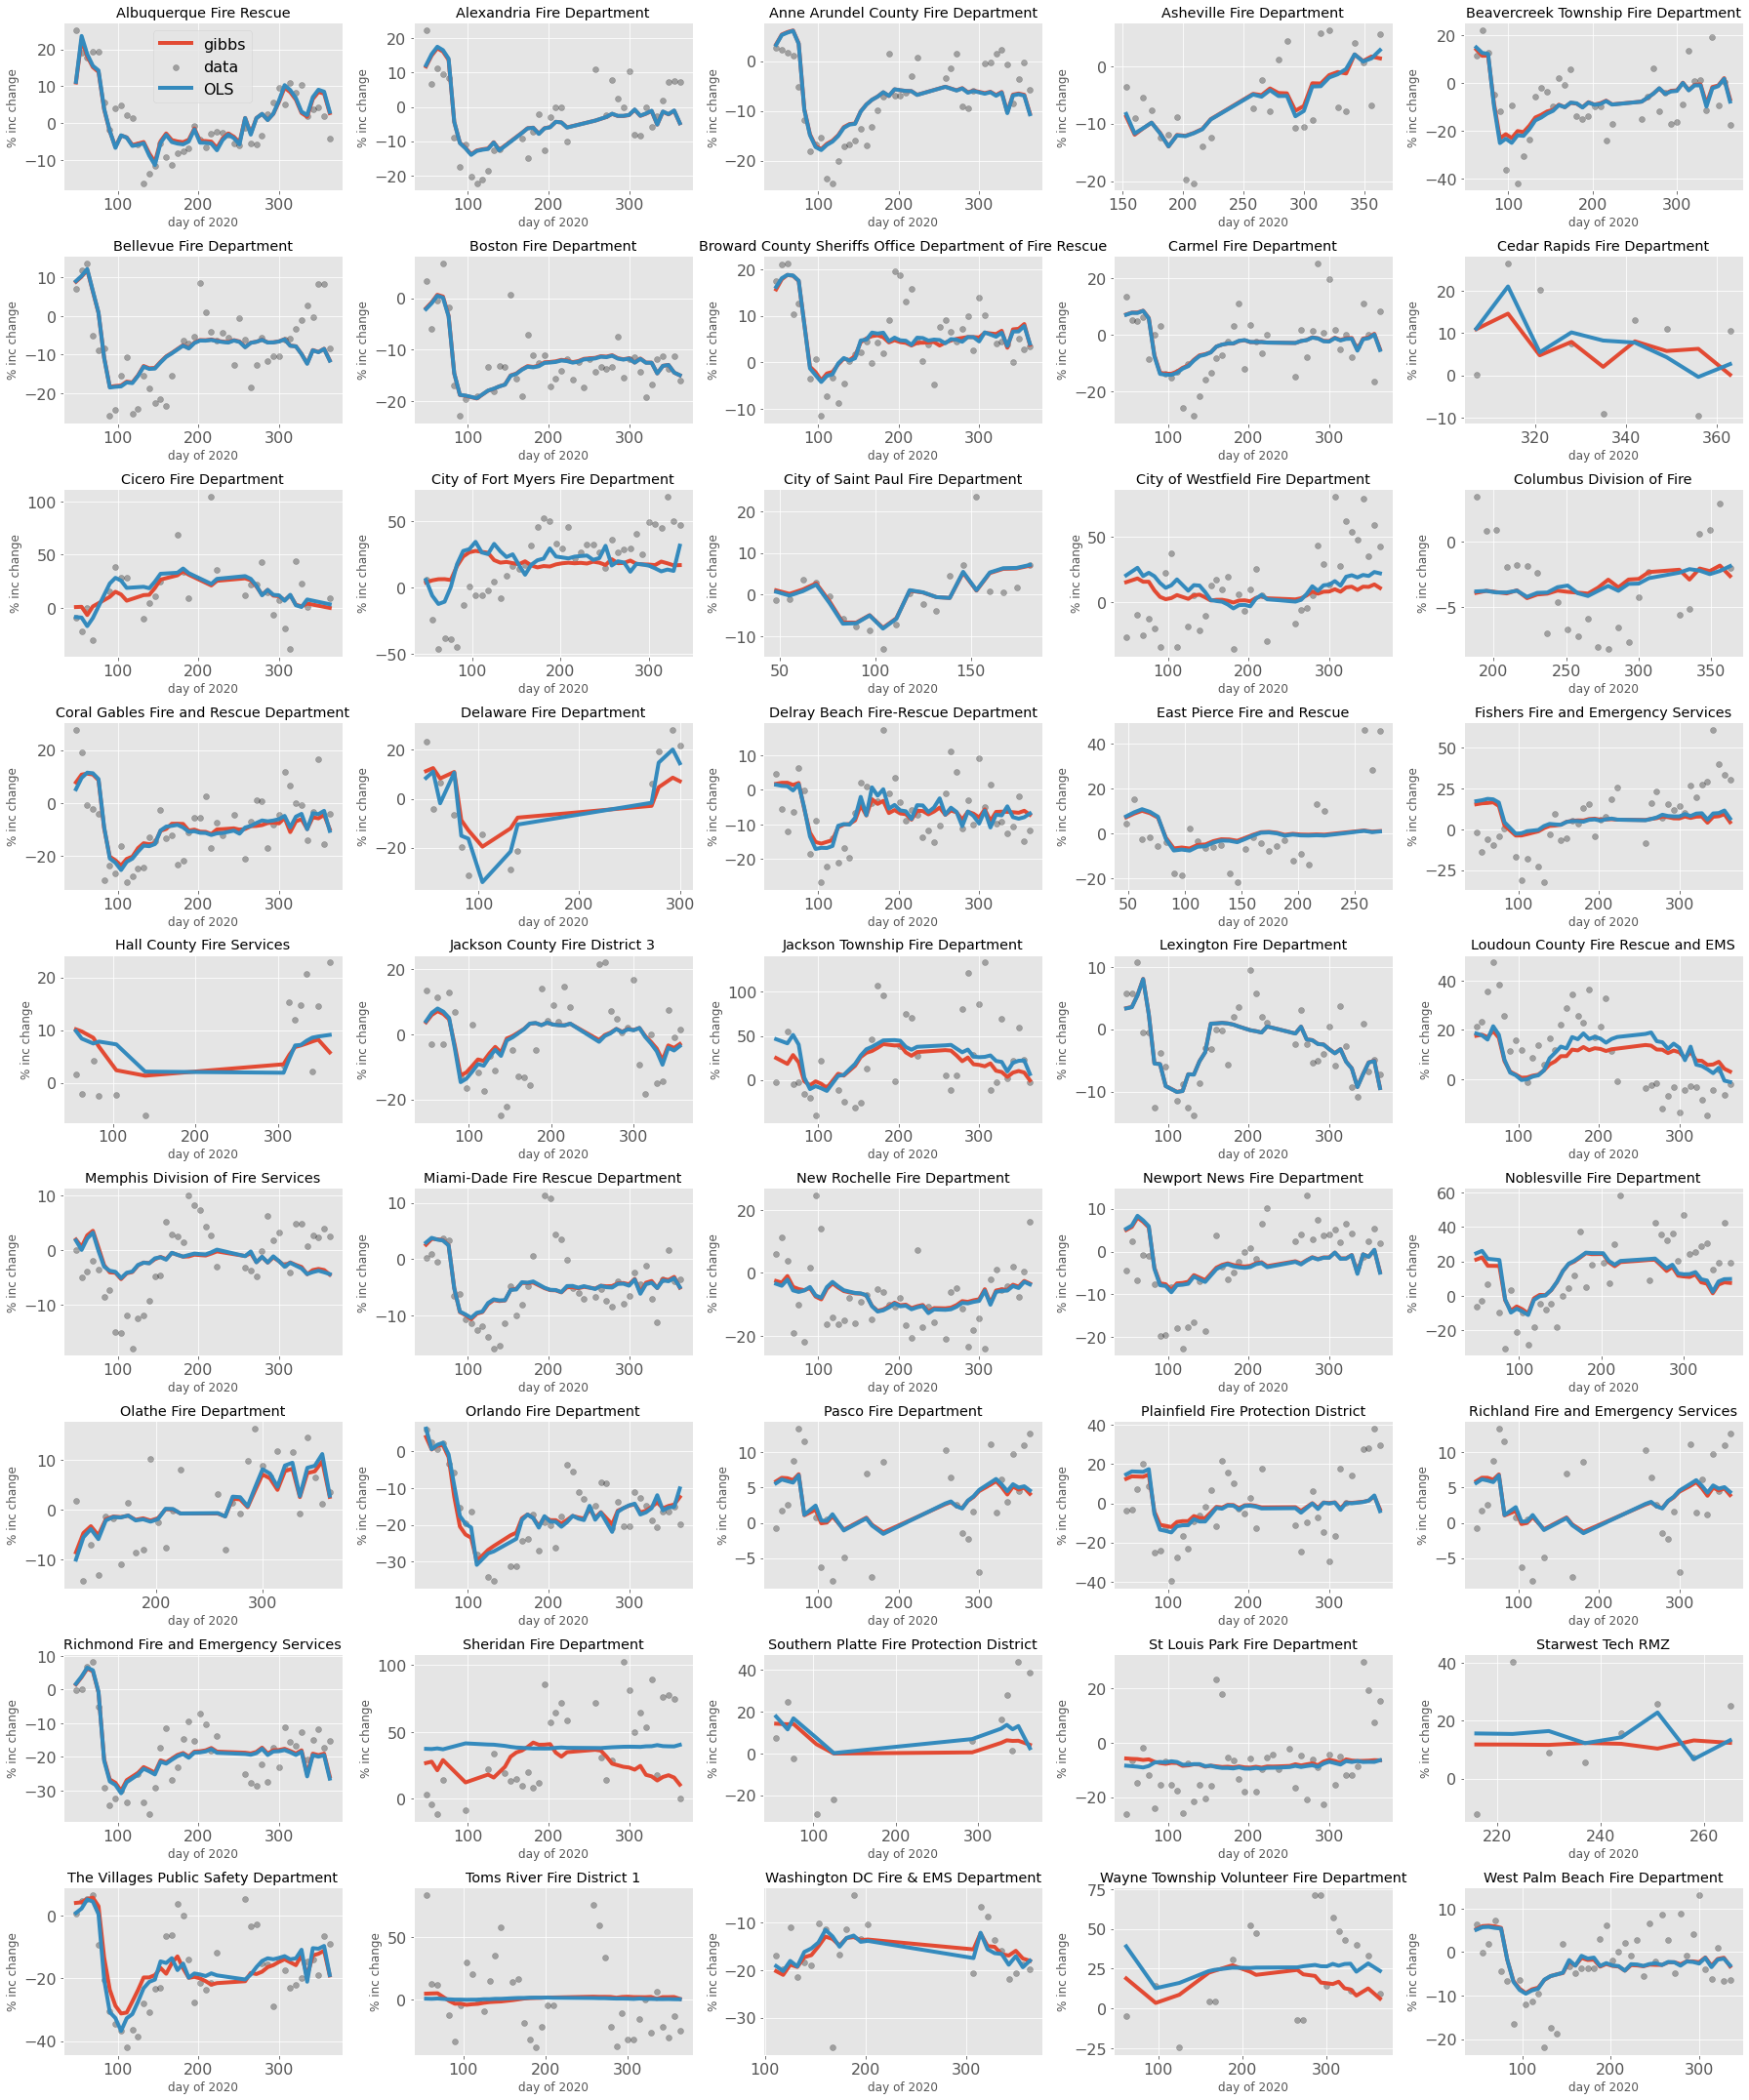

In [280]:
fig